## REST Web Service For Document Classification [Classification Model based on CV]

### Colab specific sell

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('drive/MyDrive/Projects/Interview_ML_engineer')

Mounted at /content/drive


### Importing Necessary Libraries 

In [2]:
# import necessary libraries
import tensorflow as tf
from keras import backend as k
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
from multiprocessing import Process
import multiprocessing
import codecs
import random as r
import time
import math
import itertools
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import log_loss,confusion_matrix
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,MaxPooling2D,Conv2D,Dropout,BatchNormalization
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.utils import np_utils
from keras.preprocessing import image
from sklearn.datasets import load_files
import cv2
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,precision_score,recall_score
from statistics import mode
from sklearn.utils.multiclass import unique_labels
from skimage import io

## Data preprocessing

In [3]:
##### Read description data

# Read label names
label_names = list()

with open('labels_desription.txt', 'r') as f:
    for line in f:
        label_names.append(line.split('. ')[1].strip())

# Read labels
labels = json.load(open('train_1000.json'),)

# Convert json to csv representation
label_set = pd.DataFrame(columns=['name', 'label'])

for label_ind in range(len(label_names)):
    for name in labels[str(label_ind)]:
        label_set = label_set.append({'name': name, 'label': label_ind},
                                     ignore_index=True)

# Split dataset on train, validate and test subsets with 0.7, 0.15, 0.15 proportion
train_labels, val_labels, test_labels = \
    np.split(label_set.sample(frac=1, random_state=42), 
            [int(.7*len(label_set)), int(.85*len(label_set))])

# denifing the metadatas
train_dir='train'
test_dir='test'
val_dir='val'

We will create the directory structure comapatible with keras ImageDataGenerator.

**Note:** uncomment in case you want to make this file structure again.


In [88]:
# # Moving files for subset directory from common directory
# for folder in ['test', 'train', 'val']:
#     # Creating train,validation and Test directories
#     os.mkdir(folder)
#     # Create labeled folders
#     for label_name in label_names:
#         if not os.path.exists(folder + '/' + label_name):
#             os.mkdir(folder + '/' + label_name)

# for labels, subset in zip([train_labels, val_labels, test_labels], ['train', 'val', 'test']):
#     for ind, label in tqdm(labels.iterrows(), total=len(labels)):
#         if os.path.exists('interview/' + label['name']):
#             source = 'interview/' + label['name']
#             dest = subset + '/' + label_names[label['label']]
            
#             if not os.path.exists(dest + '/' + label['name']):
#                 shutil.move(source, dest)

### Exploratory Data Analysis:

In [89]:
# sanity check if the folder structure is proper
print('Total No of folders present in Train:', len(os.listdir(train_dir)))
print('Total No of folders present in Test:', len(os.listdir(test_dir)))
print('Total No of folders present in Val:', len(os.listdir(val_dir)))

Total No of folders present in Train: 16
Total No of folders present in Test: 16
Total No of folders present in Val: 16


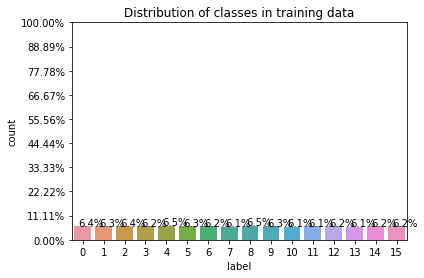

In [90]:
total = len(train_labels)
ax = sns.countplot(x=train_labels.label, data=train_labels)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.2, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 10))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.2f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.title('Distribution of classes in training data')
plt.show()

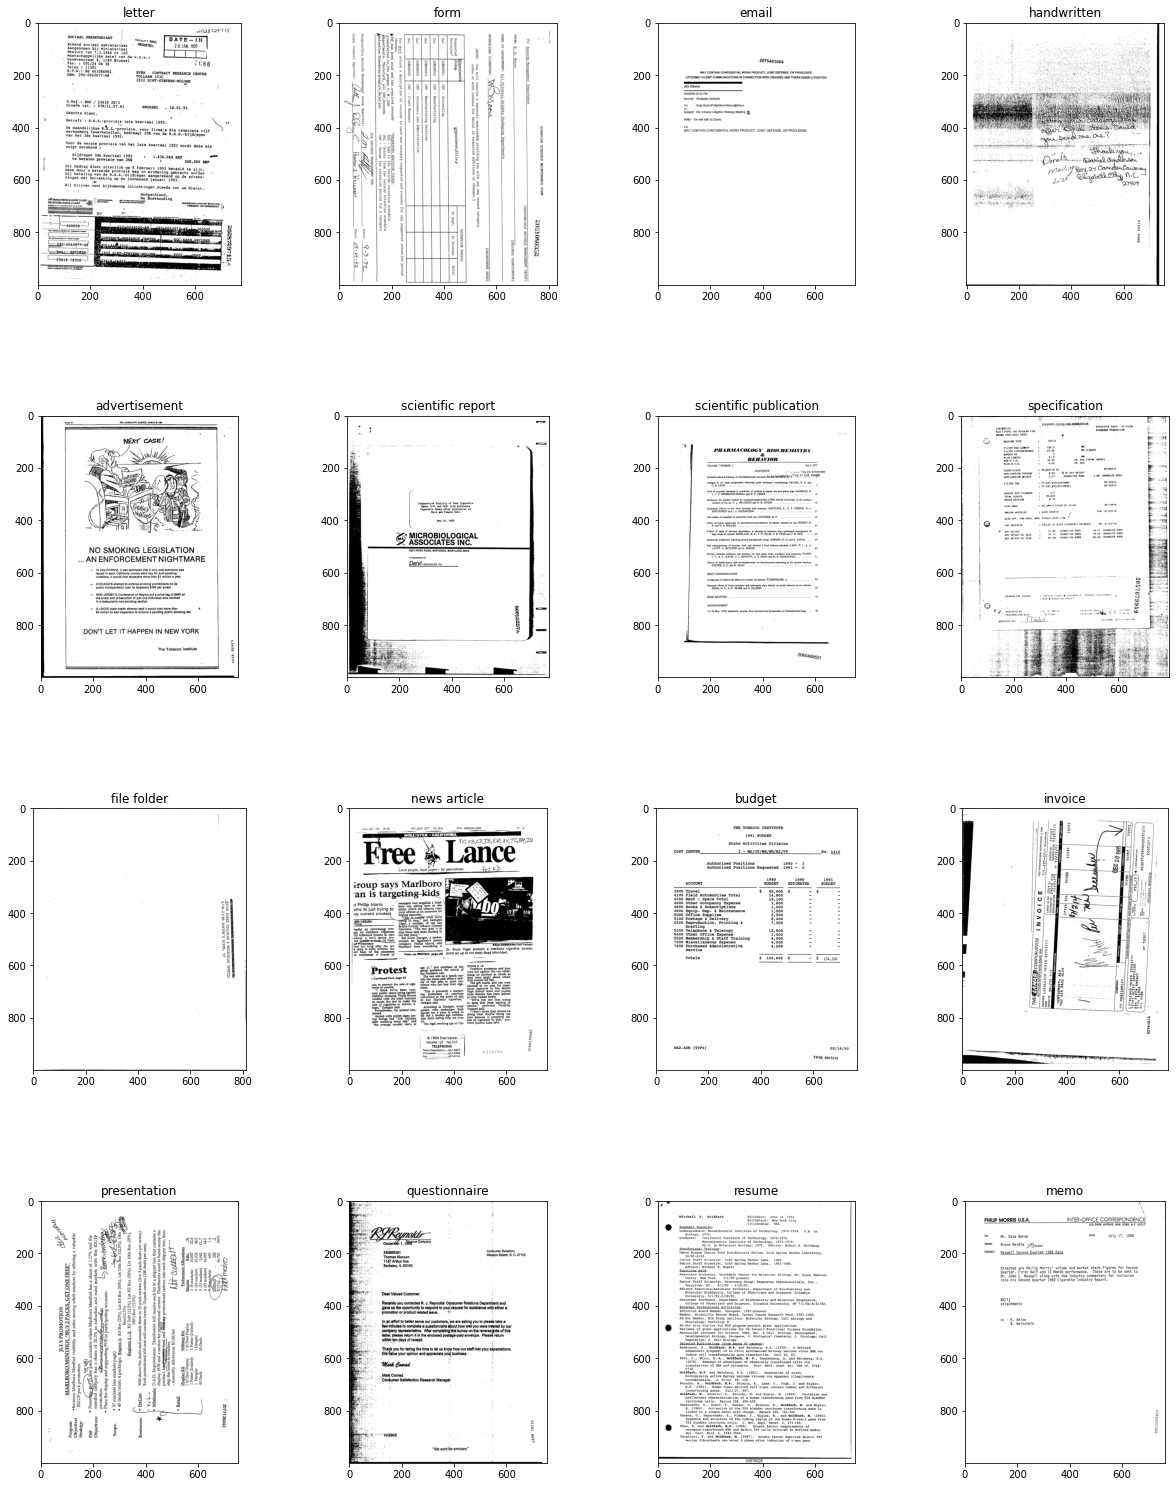

In [91]:
# sample from all the classes
fig, ax = plt.subplots(4, 4)
fig.subplots_adjust(0, 0, 5, 5, -0.75, 0.5)

for i, j in itertools.product(range(4), range(4)):
    folder = train_dir + '/' + label_names[i*4 + j]
    path = folder + '/' + os.listdir(folder)[5]

    pt = plt.imread(path)
    ax[i, j].imshow(pt, cmap='gray')
    ax[i, j].set_title(label_names[i*4 + j])

**None:** uncomment if you want to repeat extracting mean pixel intensity and image size.

In [4]:
# # Extract image size and mean pixel intensity
# #--- Mean pixel Intensity= (sum of all pixel values)/no of pixel values
# file_size = list()
# mean_pixel = list()

# for ind, label in tqdm(train_labels.iterrows(), total=len(train_labels)):
#     path = train_dir + '/' + label_names[label['label']] + '/' + label['name']

#     mean_pixel.append(np.mean(io.imread(path)))
#     file_size.append(os.stat(path).st_size/(1024.0*1024.0))

# train_labels['mean_pixel'] = mean_pixel
# train_labels['file_size'] = file_size

# train_labels.to_csv('train_labels.csv')
# test_labels.to_csv('test_labels.csv')
# val_labels.to_csv('val_labels.csv')

train_labels = pd.read_csv('train_labels.csv')
test_labels = pd.read_csv('test_labels.csv')
val_labels = pd.read_csv('val_labels.csv')

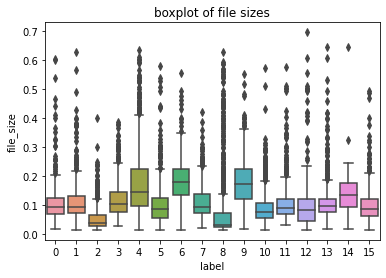

In [92]:
# boxplot of file sizes
ax = sns.boxplot(x="label", y="file_size", data=train_labels)
plt.title("boxplot of file sizes")
plt.show()

From the boxplot we can observe that size of some type of scanned documents are quiet different than others, but there are also overlaps. For example, the file size of class 13 and class 9 are much different but size of class 9 overlaps with class 4 and class 6.

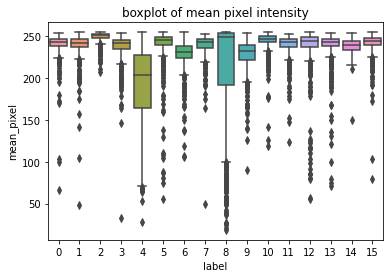

In [93]:
# Boxplot of mean pixel intensity
ax = sns.boxplot(x="label", y="mean_pixel", data=train_labels)
plt.title("boxplot of mean pixel intensity")
plt.show()

We can observe that for 75% of the cases, mean pixel intensity of class 4 lies between 160-230 pixels.But for approx 50% cases it also overlaps with mean pixel value of class 6. For other classes, mean pixel value overlaps.

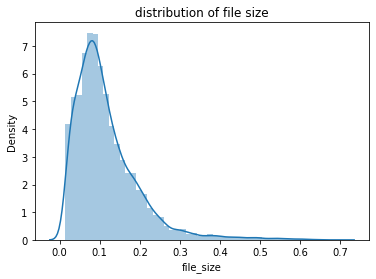

In [94]:
sns.distplot(train_labels.file_size)
plt.title("distribution of file size")
plt.show()

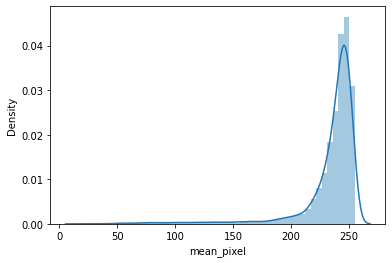

In [95]:
sns.distplot(train_labels.mean_pixel)

### Training Configuration

In [98]:
# Training configuaration for CNN- to be trained on whole images
img_width, img_height = 224, 224
nb_train_samples = len(train_labels)
nb_validation_samples = len(val_labels)
batch_size = 50
epochs = 20
num_classes = len(label_names)
log = list()

#### Training and Validation Data generator on the flow:

In [99]:
# preparing Training and Validation data using
# ImageDataGenerator with some data augmentation
train_datagen = ImageDataGenerator(
rescale = 1./255,
featurewise_std_normalization = True,
zca_whitening = True,
horizontal_flip = True,
vertical_flip = True,
channel_shift_range = 100,
brightness_range = [0., 100.])

val_datagen = ImageDataGenerator(
rescale = 1./255,
featurewise_std_normalization = True)

train_generator = train_datagen.flow_from_directory(
train_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

val_generator = val_datagen.flow_from_directory(
val_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

Found 11201 images belonging to 16 classes.
Found 2400 images belonging to 16 classes.


### Augmentation example

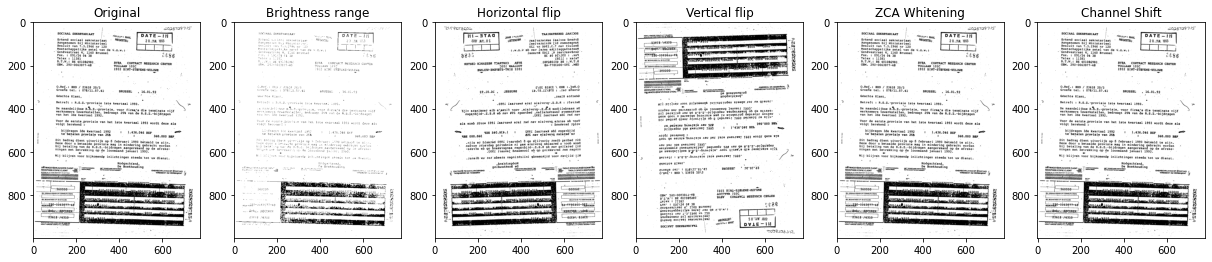

In [112]:
from keras.preprocessing.image import *
fig, ax = plt.subplots(1, 6, figsize=(21, 10))
ax = ax.ravel()

folder = train_dir + '/' + label_names[0]
path = folder + '/' + os.listdir(folder)[5]
img = plt.imread(path)

ax[0].imshow(img, cmap='gray')
ax[1].imshow(next(ImageDataGenerator(brightness_range = [0., 100.]).
                  flow(img[np.newaxis,:,:,np.newaxis]))[0,:,:,0], cmap='gray')
ax[2].imshow(next(ImageDataGenerator(horizontal_flip = True).
                  flow(img[np.newaxis,:,:,np.newaxis]))[0,:,:,0], cmap='gray')
ax[3].imshow(next(ImageDataGenerator(vertical_flip = True).
                  flow(img[np.newaxis,:,:,np.newaxis]))[0,:,:,0], cmap='gray')
ax[4].imshow(next(ImageDataGenerator(zca_whitening = True).
                  flow(img[np.newaxis,:,:,np.newaxis]))[0,:,:,0], cmap='gray')
ax[5].imshow(next(ImageDataGenerator(channel_shift_range = 100).
                  flow(img[np.newaxis,:,:,np.newaxis]))[0,:,:,0], cmap='gray')

ax[0].set_title('Original')
ax[1].set_title('Brightness range')
ax[2].set_title('Horizontal flip')
ax[3].set_title('Vertical flip')
ax[4].set_title('ZCA Whitening')
ax[5].set_title('Channel Shift');

#### Transfer learning using pretrained InceptionResNetv2 (ImageNet weights)

In [32]:
# Importing keras InceptionRsnetv2 pretrained model (on ImageNet)
# We will use the ImageNet weight to initialize the model and fine tune using backpropagation(Transfer Learning) 
from keras import regularizers
model = applications.InceptionResNetV2(weights="imagenet", include_top=False,
                                       input_shape=(img_width, img_height, 3))

#Adding custom Layers 
x = model.output
x = Dropout(0.97)(x)
x = Flatten()(x)

output = Dense(num_classes, activation="softmax")(x)
model = Model(model.input, output)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_609 (Conv2D)             (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_609 (BatchN (None, 111, 111, 32) 96          conv2d_609[0][0]                 
__________________________________________________________________________________________________
activation_609 (Activation)     (None, 111, 111, 32) 0           batch_normalization_609[0][0]    
____________________________________________________________________________________________

In [33]:
# Training for 60 epochs
import keras
from keras.callbacks import ReduceLROnPlateau

adam=keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

early_stopping_monitor = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0,
    patience = 10,
    verbose = 0,
    mode = 'auto',
    baseline = None,
    restore_best_weights = True
)
checkpoint = ModelCheckpoint("logs/Inception-ResNet-v2-2.h5", monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='auto')
callbacks = [early_stopping_monitor, checkpoint]

history = model.fit_generator(
train_generator,
steps_per_epoch = 100,
epochs = 60,
validation_data = val_generator,
validation_steps = 10,
callbacks = callbacks, verbose = 1)

log.append(history)

Epoch 1/60
100/100 [==============================] - 105s 901ms/step - loss: 4.9573 - accuracy: 0.0769 - val_loss: 2.8286 - val_accuracy: 0.0600

Epoch 00001: val_accuracy improved from -inf to 0.06000, saving model to logs/Inception-ResNet-v2-2.h5
Epoch 2/60
100/100 [==============================] - 88s 877ms/step - loss: 3.1322 - accuracy: 0.0793 - val_loss: 2.7237 - val_accuracy: 0.0960

Epoch 00002: val_accuracy improved from 0.06000 to 0.09600, saving model to logs/Inception-ResNet-v2-2.h5
Epoch 3/60
100/100 [==============================] - 89s 881ms/step - loss: 3.0143 - accuracy: 0.1075 - val_loss: 2.6451 - val_accuracy: 0.1140

Epoch 00003: val_accuracy improved from 0.09600 to 0.11400, saving model to logs/Inception-ResNet-v2-2.h5
Epoch 4/60
100/100 [==============================] - 89s 884ms/step - loss: 2.8904 - accuracy: 0.1276 - val_loss: 2.6663 - val_accuracy: 0.1040

Epoch 00004: val_accuracy did not improve from 0.11400
Epoch 5/60
100/100 [=========================

#### Visualization of loss and accuracy after phase I:

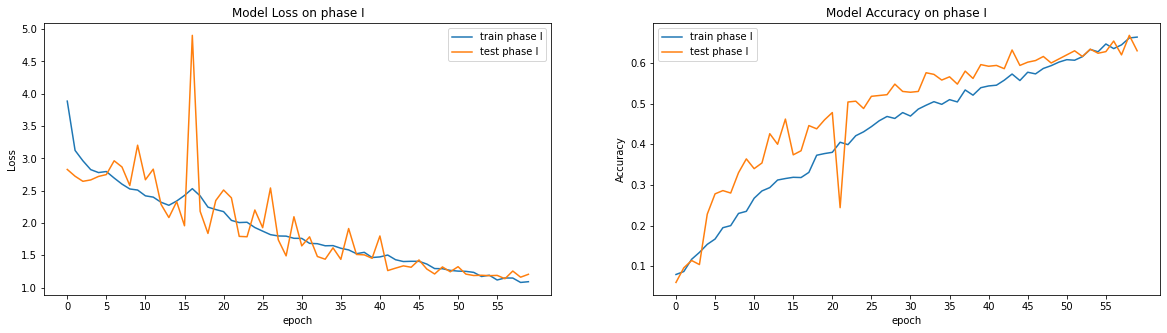

In [86]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Model Loss on phase I')
axes[0].set_ylabel('Loss')
axes[0].set_xticks(np.arange(0, len(history.history['loss']), 5))
axes[0].set_xlabel('epoch')
axes[0].legend(['train phase I', 'test phase I'])

axes[1].plot(history.history['accuracy'])
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title('Model Accuracy on phase I')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticks(np.arange(0, len(history.history['accuracy']), 5))
axes[1].set_xlabel('epoch')
axes[1].legend(['train phase I', 'test phase I']);

In [45]:
# saving training log for first 60 epochs
with open('logs/log-2.pkl', 'wb') as file_pi:
      pickle.dump(history.history, file_pi)

After running for 60 epochs with adam optimizer, we obtained an accuracy of 67%. We can see that the loss is not improving over last epochs.We will train the network for more epochs with adam optimizer and decaying learning rate. If  val_acc does not improve in 4 epochs we will reduce the learning rate automatically using callback.   

In [38]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=4, min_lr=1e-7, mode='auto')
callbacks = [early_stopping_monitor, checkpoint, reduce_lr]

history2 = model.fit_generator(
train_generator,
steps_per_epoch = 100,
epochs = 60,
validation_data = val_generator,
validation_steps = 10,
callbacks = callbacks, verbose = 1)

log.append(history2)

Epoch 1/60
100/100 [==============================] - 102s 926ms/step - loss: 1.0593 - accuracy: 0.6638 - val_loss: 1.1473 - val_accuracy: 0.6420

Epoch 00001: val_accuracy did not improve from 0.66800
Epoch 2/60
100/100 [==============================] - 89s 883ms/step - loss: 1.0922 - accuracy: 0.6570 - val_loss: 1.2748 - val_accuracy: 0.6620

Epoch 00002: val_accuracy did not improve from 0.66800
Epoch 3/60
100/100 [==============================] - 89s 887ms/step - loss: 1.0546 - accuracy: 0.6734 - val_loss: 1.2139 - val_accuracy: 0.6240

Epoch 00003: val_accuracy did not improve from 0.66800
Epoch 4/60
100/100 [==============================] - 89s 886ms/step - loss: 1.0184 - accuracy: 0.6884 - val_loss: 1.2483 - val_accuracy: 0.6480

Epoch 00004: val_accuracy did not improve from 0.66800
Epoch 5/60
100/100 [==============================] - 89s 888ms/step - loss: 1.0014 - accuracy: 0.6838 - val_loss: 1.1430 - val_accuracy: 0.6420

Epoch 00005: val_accuracy did not improve from 0.

In [46]:
# saving training log for second 60 epochs
with open('logs/log-22.pkl', 'wb') as file_pi:
      pickle.dump(history2.history, file_pi)

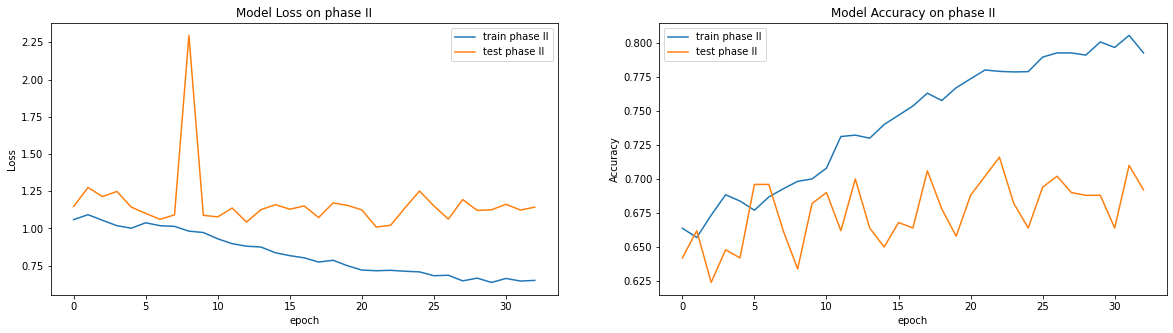

In [87]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

axes[0].plot(history2.history['loss'])
axes[0].plot(history2.history['val_loss'])
axes[0].set_title('Model Loss on phase II')
axes[0].set_ylabel('Loss')
axes[0].set_xticks(np.arange(0, len(history2.history['loss']), 5))
axes[0].set_xlabel('epoch')
axes[0].legend(['train phase II', 'test phase II'])

axes[1].plot(history2.history['accuracy'])
axes[1].plot(history2.history['val_accuracy'])
axes[1].set_title('Model Accuracy on phase II')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticks(np.arange(0, len(history2.history['accuracy']), 5))
axes[1].set_xlabel('epoch')
axes[1].legend(['train phase II', 'test phase II']);

After running for more than 30 epochs, we achieved almost a 5% gain in accuracy. It can be seen that loss decreasing on the training set, while this does not happen on the validation set. Thus, further training threatens us with retraining the model, so let's stop.

### Evaluation on the test set

In [58]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from statistics import mode
from sklearn.utils.multiclass import unique_labels
from keras.models import load_model

model = load_model('logs/Inception-ResNet-v2-2.h5')

# Test Data generator to generate test data in same format of training data
test_datagen = ImageDataGenerator(
rescale = 1./255,
featurewise_std_normalization = True)

x, y = test_datagen.flow_from_directory(
test_dir,
target_size = (img_height, img_width),
batch_size = len(test_labels),
class_mode = "categorical").next()

y_pred = list()
y_true = list()

for i in range(len(x)):
    pred = model.predict(np.expand_dims(x[i], axis=0))
    
    y_pred.append(np.argmax(pred))
    y_true.append(np.argmax(y[i]))

print('-------------Model Evaluation-------------')

accuracy = np.round(accuracy_score(y_pred, y_true), 3)
f1 = np.round(f1_score(y_pred, y_true, average='macro'), 3)
precision = np.round(precision_score(y_pred, y_true, average='macro'), 3)
recall = np.round(recall_score(y_pred, y_true, average='macro'), 3)

print('Accuracy:', np.round((accuracy)*100, 2), '%')
print('Macro F1 Score:', f1)
print('Precision Score:', precision)
print('Recall Score:', recall)

Found 2400 images belonging to 16 classes.
-------------Model Evaluation-------------
Accuracy: 69.2 %
Macro F1 Score: 0.696
Precision Score: 0.694
Recall Score: 0.707


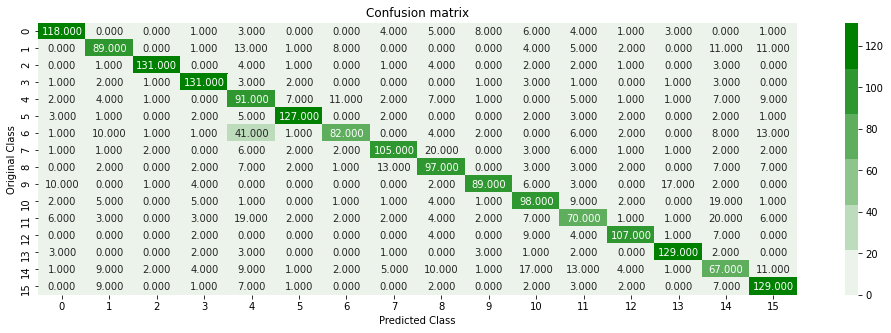

In [55]:
labels = np.arange(16)
cmap=sns.light_palette("green")
C = confusion_matrix(y_true, y_pred)

# representing C in heatmap format
plt.figure(figsize=(17,5))
sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)

plt.title('Confusion matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

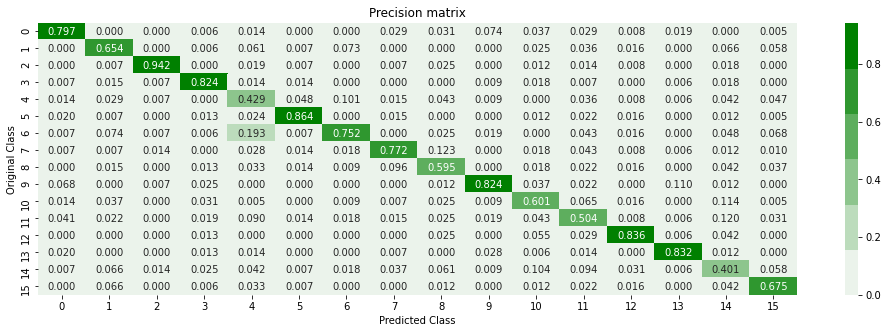

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [56]:
B = C / C.sum(axis = 0)

# representing B in heatmap format
plt.figure(figsize=(17,5))
sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)

plt.title('Precision matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

print("Sum of columns in precision matrix", B.sum(axis=0))

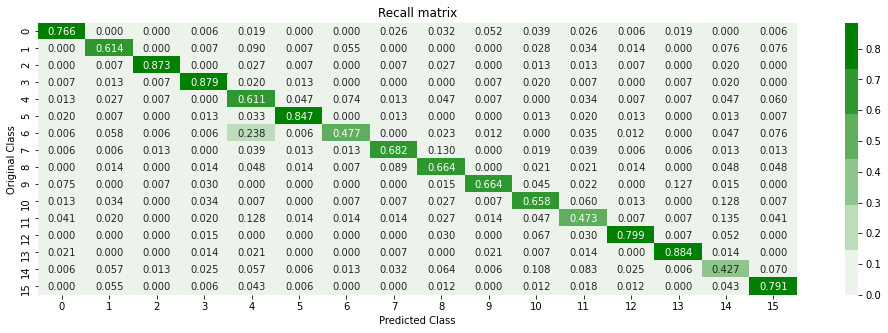

Sum of rows in recall matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [57]:
A = (C.T / C.sum(axis = 1)).T

# representing A in heatmap format
plt.figure(figsize=(17,5))
sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)

plt.title('Recall matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

print("Sum of rows in recall matrix", A.sum(axis=1))

Let's see top 3 predicted labels

In [113]:
from keras.preprocessing import image

chosen_label = np.random.choice(os.listdir(test_dir))
chosen_image = np.random.choice(os.listdir(test_dir + '/' + chosen_label))

img = image.load_img('/'.join([test_dir, chosen_label, chosen_image]),
                     target_size = (img_height, img_width))
img = image.img_to_array(img).astype('float32') / 255.
img = np.expand_dims(img, axis = 0)

pred = model.predict(img)[0]
y_pred = np.sort(label_names)[np.argmax(pred)]
y_true = chosen_label

print('Top 3 predicted labels:')

for ind, label_ind in enumerate(np.argsort(pred)[::-1][:3]):
    print('{0}. {1} with {2}% probability.'.
          format(ind+1, np.sort(label_names)[label_ind].capitalize(),
                 np.round(pred[label_ind]*100, 1)))

print('\nTrue label: {0}.'.format(y_true.capitalize()))

Top 3 predicted labels:
1. Email with 93.4% probability.
2. Resume with 2.9% probability.
3. Questionnaire with 0.8% probability.

True label: Email.


### Conslusion:

The performance of the final model on the test set is nearly 70%. An attempt to extract the text using the OCR method and further text analysis may be promising. Since this model will use completely different features, it can be combined with the results of the current algorithm for getting a stronger final classifier.